In [1]:
include("../ToolBox/ToolBox.jl")
import JLD
import FileIO
using .ToolBox
using .Geometry
using Colors

In [2]:
master_folder = "/Users/simon/Data/Sentinel/vejle_oktober/S1B_IW_SLC__1SDV_20191005T170849_20191005T170916_018343_0228DC_F565.SAFE"
slave_folder = "/Users/simon/Data/Sentinel/vejle_oktober/S1A_IW_SLC__1SDV_20191011T170932_20191011T170959_029414_035865_06AB.SAFE"

#dem
dem_path = "/Users/simon/Data/DEM/denmark.jld";

# pod
master_pod_path = Load.pod_path(master_folder)
slave_pod_path = Load.pod_path(slave_folder);

In [3]:
polarization = "VV"
subswath = 3

# Paths 
master_data_path, master_meta_path, master_cal_path = Load.slc_paths(master_folder, polarization, subswath)
slave_data_path, slave_meta_path, slave_cal_path = Load.slc_paths(slave_folder, polarization, subswath);

In [4]:
master_view = [9500:11500,1200:6000];

In [5]:
# load meta and pod
master_meta = Load.slc_meta(master_meta_path);
master_precise_orbit = Load.precise_orbit(master_pod_path,master_meta["t_0"]);
slave_meta = Load.slc_meta(slave_meta_path);
slave_precise_orbit = Load.precise_orbit(slave_pod_path,slave_meta["t_0"]);

meta = (master_meta,slave_meta)
precise_orbit = (master_precise_orbit,slave_precise_orbit);

In [6]:
pad = 0.1
dem = JLD.load(dem_path);
footprint = SlcUtil.footprint(master_meta, master_view)
latlon_window = ((minimum(footprint[1]), maximum(footprint[1])), (minimum(footprint[2]), maximum(footprint[2])))
idx1 =(latlon_window[1][1] - pad) .<dem["lat"].< (latlon_window[1][2] + pad)
idx2 =(latlon_window[2][1] - pad) .<dem["lon"].< (latlon_window[2][2] + pad)
dem = (dem["lat"][idx1], dem["lon"][idx2], dem["height"][idx1,idx2]);
dem[3][dem[3].<0] .= 0;

In [7]:
slave_data,flat,lut =  coregister_slave(master_view,slave_data_path,meta,precise_orbit,dem)
slave_data,mosaic_view = SlcUtil.mosaic(slave_data,master_view,meta[1]);
flat,mosaic_view = SlcUtil.mosaic(flat,master_view,meta[1]);

master_data = Load.slc_data(master_data_path,master_view);
master_data,mosaic_view = SlcUtil.mosaic(master_data,master_view,meta[1]);

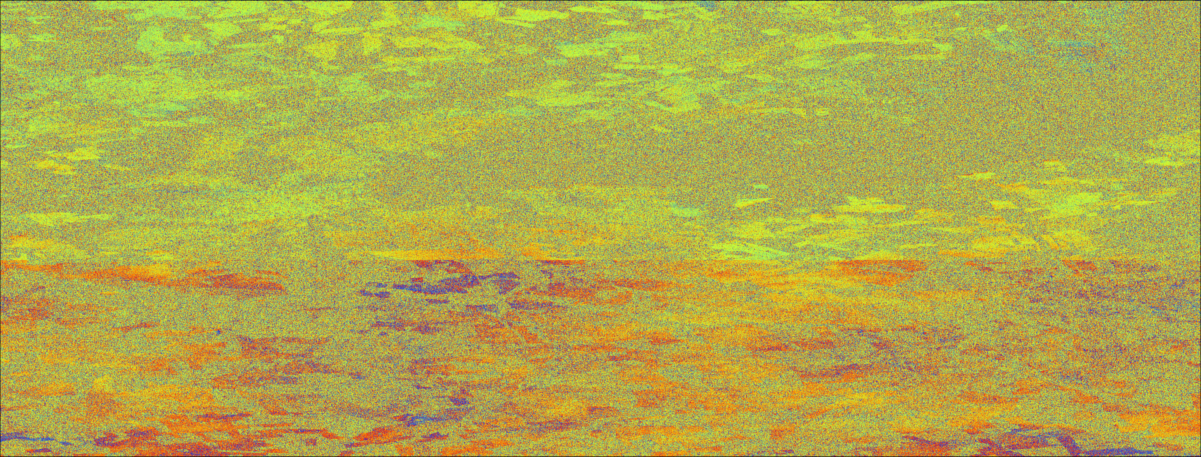

In [8]:
SlcUtil.plot_phase(master_data.*conj.(slave_data).*flat)

In [9]:
kernel = ones(4,14)
complex_coherence, master_intensity, slave_intensity, lines, samples = SlcUtil.complex_coherence(master_data, slave_data, flat, kernel, mosaic_view);

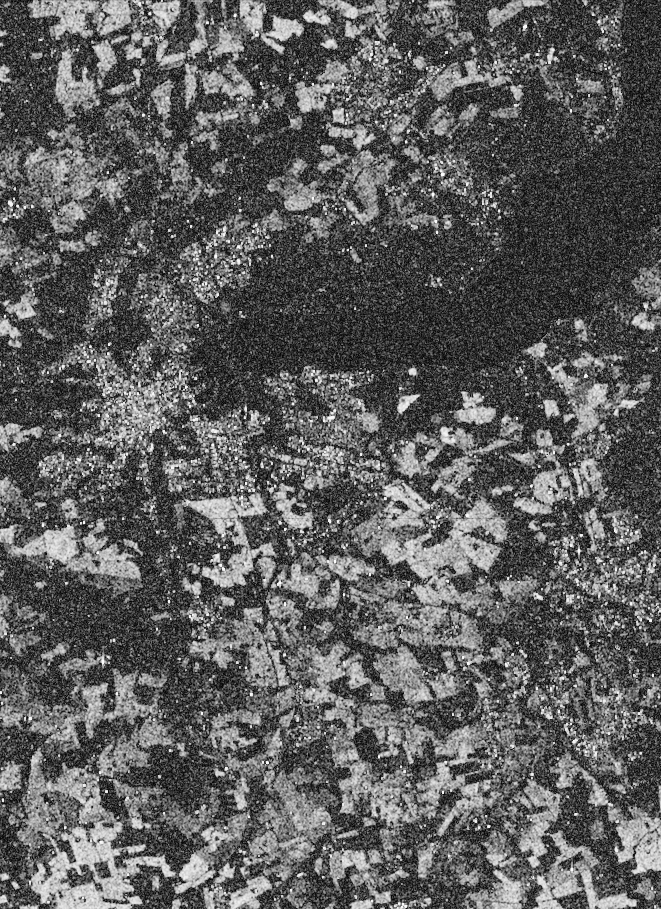

In [10]:
coherence_img = Gray.(abs.(complex_coherence[1:2:end,150:7:end]))